# Correlation

The correlation step takes signals from a pair of telescopes and
computes the Fourier transform of their cross correlations.
A significant property of such an operation is to remove the noise
from the visibility data.

Let $s$ be the sky signal from some radio source.
When the sky signal arrives at telescopes 1 and 2, the recorded
signals $s_1$ and $s_2$, although may have a time delay due to
geometric effects, are correlated.
Let $n_1$ and $n_2$ be noise at each of the telescopes, the cross
correlation is
\begin{align}
  X &= \langle (s_1 + n_1) (s_2 + n_2) \rangle \\
    &= \langle s_1 s_2 \rangle
     + \langle s_1 n_2 \rangle
     + \langle s_2 n_1 \rangle
     + \langle n_1 n_2 \rangle.
\end{align}
All the terms other than first term should vanishes.

By taking the Fourier transform of such a cross correlation, we obtain
also the spectral information of the signal.

In this chapter, we will create synthetic very long baseline
interferometry (VLBI) data and demostrate how cross-correlation can
remove the noise.
We will also show the XF and FX correlators are mathematically
identical, although the FX correlator is computationally more
efficient.

To get started, we first import the standard python packages:

In [1]:
import numpy as np
from math import pi, ceil
from matplotlib import pyplot as plt

## Signal Generation

We consider monochromatic radio wave at unit frequency.

Using `numpy`, we create a time array `t` and then generate the
recorded signals `s1` and `s2` at the two telescopes.

The signal at telescope 2 has a lag of $1.2345/2\pi$ unit time
compared to telescope 1.

In [2]:
t  = np.linspace(0, 10_000, num=100_000)
s1 = np.sin(2 * pi * t)
s2 = np.sin(2 * pi * t - 1.2345)

Plotting the two signals,

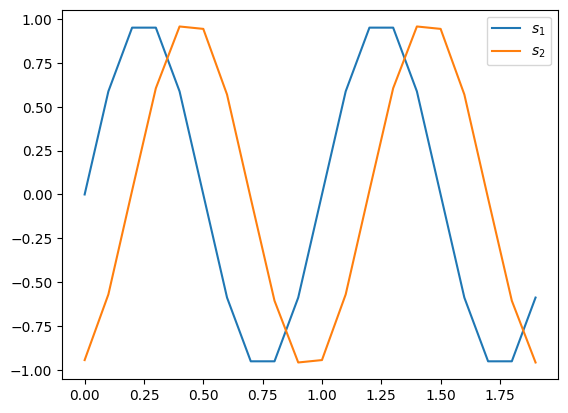

In [3]:
plt.plot(t[:20], s1[:20], label=r'$s_1$')
plt.plot(t[:20], s2[:20], label=r'$s_2$')
plt.legend()

## XF Correlator

Cross correlation is defined by:
\begin{align}
  X(f, g)(\tau) = \int f^*(t) g(t + \tau) dt = \int f^*(t - \tau) g(t) dt,
\end{align}
where $^*$ indicates complex conjugate.

For VLBI, we only care about the discrete version of this.
Hence we can replace $g(t + \tau)$ by `np.roll()`:

In [4]:
tau = 1

print(np.roll(np.arange(10), tau)) # <- this is convolution
print(np.roll(np.arange(10),-tau)) # <- this is correlation

[9 0 1 2 3 4 5 6 7 8]
[1 2 3 4 5 6 7 8 9 0]


The cross correlation is simply:

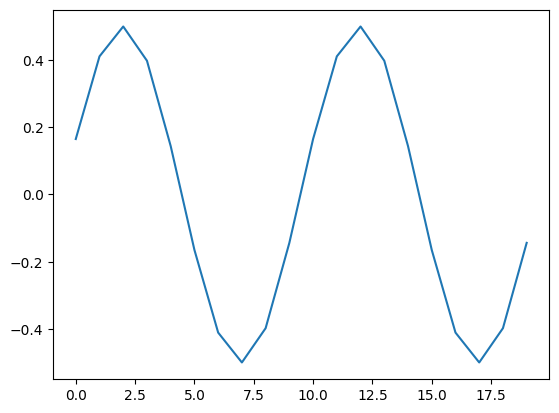

In [5]:
X = np.array([np.mean(s1 * np.roll(s2,-tau)) for tau in range(0,100_000)])

plt.plot(X[:20])

Applying the Fourier transform, we obtain the visibility as a function
of freqnecy:

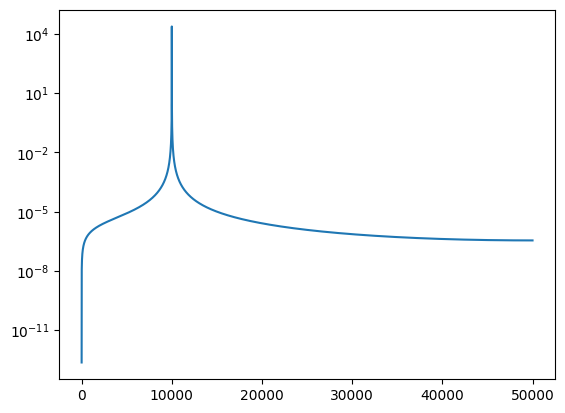

In [6]:
XF = np.fft.rfft(X)

plt.semilogy(abs(XF))

Pulling out the peak, the phase in the visibility is identical to the
lag we put in:

In [7]:
n = np.argmax(abs(XF))
V = XF[n]

print(n)
print(abs(V))
print(np.angle(V))

10000
24188.236053877215
-1.2345033298982624


## FX Correlator

Using the convolution theory, it is easy to show
\begin{align}
  \widehat{X(f, g)}_k = \hat{f}_k^* \hat{g}_k.
\end{align}
Hence, instead of first computing the cross correlation in time domain
and then applying the Fourier transform, we can perform the Fourier
transform first, and then compute the *element-wise* products in
frequency domain.
Correlators that use this methods are referred to as FX correlators,
which can we easily implement in python:

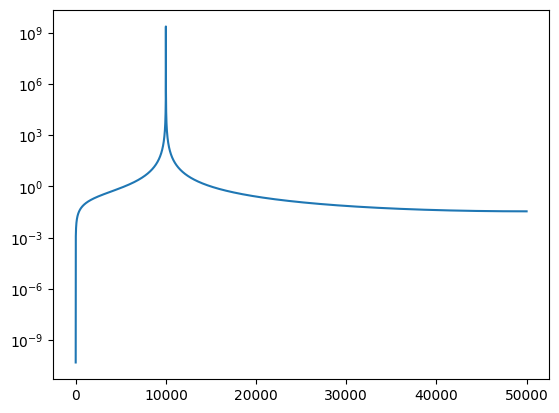

In [8]:
S1 = np.fft.rfft(s1)
S2 = np.fft.rfft(s2)
FX = np.conj(S1) * S2

plt.semilogy(abs(FX))

Pulling out the peak, the phase in the visibility is identical to the
lag we put in, just like in the XF correlator:

In [9]:
n = np.argmax(abs(FX))
V = FX[n]

print(n)
print(abs(V))
print(np.angle(V))

10000
2418823605.3877215
-1.2345033298982624


## Introducing Noise

We argued at the beginning that cross correlation removes noise from
the data.
To demostrate this, let's introduce noise in our simple python codes
with a signal-to-noise ratio at unity.

SNR = 0.9985502793212226
SNR = 1.0085815629086643


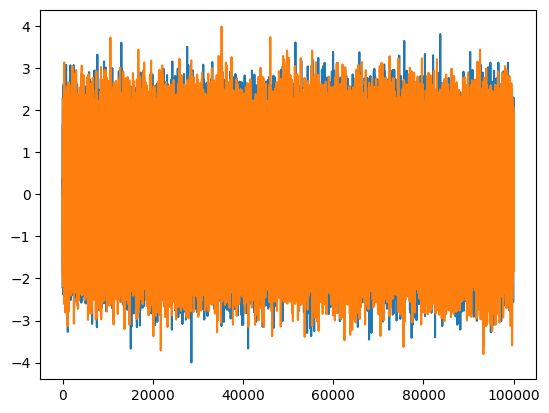

In [10]:
n1 = np.random.normal(scale=np.sqrt(0.5), size=100_000)
n2 = np.random.normal(scale=np.sqrt(0.5), size=100_000)

print('SNR =', np.sum(s1*s1)/np.sum(n1*n1))
print('SNR =', np.sum(s2*s2)/np.sum(n2*n2))

plt.plot(s1 + n1)
plt.plot(s2 + n2)

Computing the visibility (spectrum) using the FX Correlator, we
immediate see the noise floor is almost 4 orders of magnitude lower
than the signal.

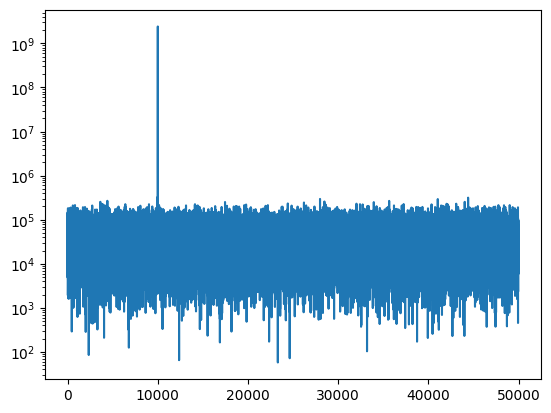

In [11]:
S1 = np.fft.rfft(s1 + n1)
S2 = np.fft.rfft(s2 + n2)
FX = np.conj(S1) * S2

plt.semilogy(abs(FX))

And the error in the phase is at percentage level.

In [12]:
n = np.argmax(abs(FX))
V = FX[n]

print(n)
print(abs(V))
print(np.angle(V))

10000
2421286601.002458
-1.2383414085305056


## Chunked Correlation

In practice, correlators do not correlate all the data in a scan all
at once.
In stead, they divide the signal into multiple chunks, correlate each
chunk, and create a time series of visibility.
Such a time series can then be averaged later to incrase the
signal-to-noise ratio.

To demonstrate such process, let's choose a chunk size of 1000,
perform FX correlation over each chunk, and plot all of the resulting
visibilities as function of frequency.

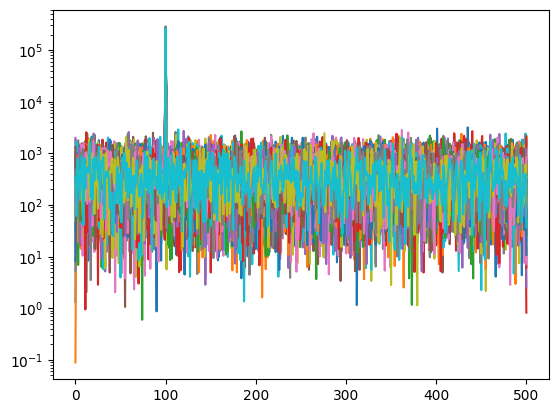

In [13]:
nc = 1000
Nc = int(ceil(len(s1) / nc) * nc)
S1 = np.fft.rfft(np.pad(s1+n1, (0, Nc-len(s1))).reshape(Nc//nc, nc))
S2 = np.fft.rfft(np.pad(s2+n2, (0, Nc-len(s2))).reshape(Nc//nc, nc))
FX = np.conj(S1) * S2

for fx in FX:
    plt.semilogy(abs(fx))

We may also look at only the "reference frequency" and plot the
amplitude and phase as function of time:

100


(-3.141592653589793, 3.141592653589793)

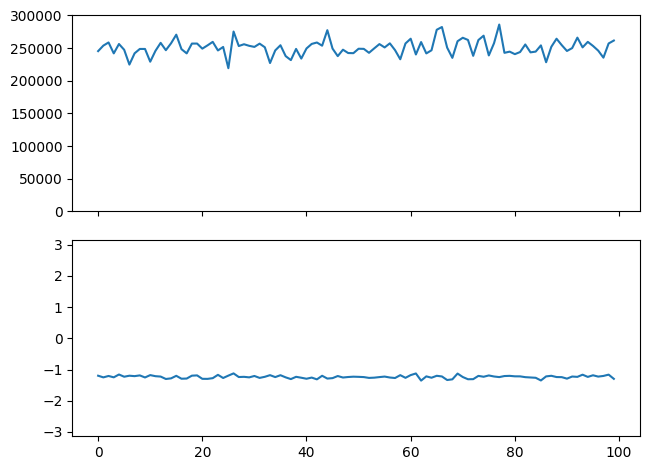

In [14]:
n = np.argmax(abs(FX[0]))
V = FX[:,n]

print(n)

fig, (ax0, ax1) = plt.subplots(2,1, sharex=True)
fig.tight_layout()

ax0.plot(abs(V))
ax0.set_ylim(0, 300_000)

ax1.plot(np.angle(V))
ax1.set_ylim(-pi, pi)

We can also perform both the coherence and incoherence averaging of
the data:

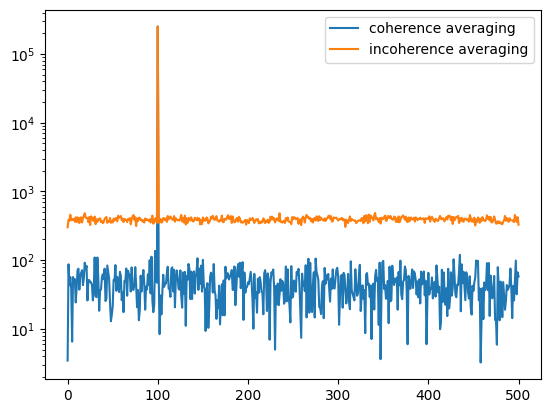

In [15]:
plt.semilogy(abs(np.mean(FX, axis=0)), label='coherence averaging')
plt.semilogy(np.mean(abs(FX), axis=0), label='incoherence averaging')
plt.legend()